In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sdeint

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
from gtda.homology import FlagserPersistence
from gtda.diagrams import Filtering

flagser_persistence = FlagserPersistence(n_jobs=-1, reduced_homology=False, directed=True, homology_dimensions=[0, 1])

# Helpful Functions

In [3]:
def get_bins(ts,b):
    d, n = ts.shape
    bins = {}
    for i in range(d):
        top = max(ts[i])
        bot = min(ts[i])
        step = (top - bot)/b
        ibins = []
        for j in range(b+1):
            ibins.append(bot+j*step)
        bins[i] = ibins
    return bins


In [4]:
def bin_sequence(ts, bins, b):
    d,n = ts.shape
    binseq = np.zeros((n))
    for i in range(n):
        bin_n = 0
        for j in range(d):
            k = 1
            while k <= b:
                if ts[j,i] <= bins[j][k]:
                    bin_n += (k-1)*(b**j)
                    k = b + 1
                else: 
                    k = k + 1 
        binseq[i] = bin_n

    return binseq

In [5]:
'''def adjacency(bin_seq):
    vertices = np.unique(bin_seq)
    order = len(vertices)
    A = np.zeros((order,order))
    for i in range(len(bin_seq)-1):
        A[np.where(vertices == bin_seq[i]),np.where(vertices == bin_seq[i+1])] += 1
    return A'''

In [6]:
'''def digraph(A, loops: bool):
    if loops == False:
        AA = np.copy(A)
        np.fill_diagonal(AA,0)
        G = nx.DiGraph(AA)
    elif loops == True:
        G = nx.DiGraph(A)
    
    return G'''

In [7]:
def distance_matrix(G, method = 'unweighted_shortest_path'):

    if method == 'unweighted_shortest_path':
        lengths = dict(nx.all_pairs_shortest_path_length(G))
        D = np.full((len(lengths),len(lengths)),300)
        for key in lengths:
            for item in lengths[key]:
                    D[key,item] = lengths[key][item]
    
    if method == 'weighted_shortest_path':
        w = nx.get_edge_attributes(G,'weight')
        for key in w:
            w[key] = 1/w[key]
        nx.set_edge_attributes(G,w,name='weight')
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),300,dtype=int)
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    return D

In [8]:
def data2distancematrix(data, X, n_bins=10, drawGraph=False, drawDist=True):

    Xbins = get_bins(X, n_bins)
    Xseq = bin_sequence(X, Xbins, n_bins)

    B = get_bins(data, n_bins)
    seq = bin_sequence(data, B, n_bins)
    vert = np.unique(seq)
    A = adjacency(seq)

    G = digraph(A, True)
    x = nx.all_pairs_shortest_path_length(G)
    lengths = dict(x)

    if drawGraph:
        nx.draw(G, with_labels=False, node_size=25)

    D = distance_matrix(G, 'weighted_shortest_path')

    if drawDist:
        plt.imshow(D)
        plt.colorbar()

    dist = D.reshape(1, *D.shape)
    
    return dist

In [9]:
def lorenz63(t, xyz, sigma=10, rho=28, beta=8.0/3.0):
    x, y, z = xyz #assign the dependent variables
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def lorenz_stochastic(tspan, x0, sigma=10, rho=28, beta=8.0/3.0, intensity=5):
    
    def f(X, t):
        A = np.array([[-sigma, sigma, 0], [rho, -1.0, -X[0]], [0, X[0], -beta]])
        return A.dot(X)
    def G(X, t):
        B = np.diag([intensity, 0, 0])
        return B
    
    result = sdeint.itoint(f, G, x0, tspan)
    return result

# Gen Data

In [10]:
'''x0 = [3.0, 3.0, 3.0]

t_span = (0, 40)
t_eval = np.linspace(*t_span, 50000)

sol = solve_ivp(lorenz63, t_span, x0, t_eval=t_eval)

x = sol.y[0]
y = sol.y[1]
z = sol.y[2]'''

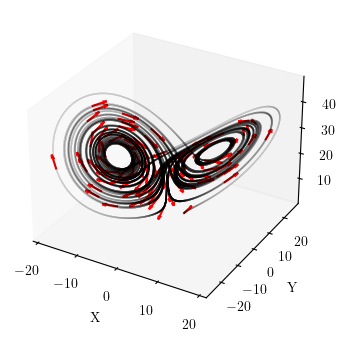

In [11]:
'''u, v, w = np.diff(x), np.diff(y), np.diff(z)

n = 500
x_quiver = x[:-1:n]
y_quiver = y[:-1:n]
z_quiver = z[:-1:n]
u_quiver = u[::n]
v_quiver = v[::n]
w_quiver = w[::n]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='k', s=0.005, alpha=0.6)
ax.quiver(x_quiver, y_quiver, z_quiver, u_quiver, v_quiver, w_quiver, length=5, normalize=True, color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.grid(False)

plt.show()'''

In [12]:
'''stochastic = lorenz_stochastic(t_eval, x0, intensity=5)

x_stoch = stochastic[:, 0]
y_stoch = stochastic[:, 1]
z_stoch = stochastic[:, 2]'''

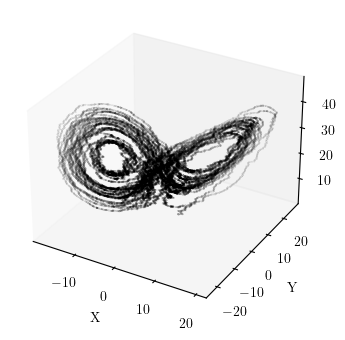

In [13]:
'''fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_stoch, y_stoch, z_stoch, c='k', s=0.005, alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.grid(False)

plt.show()'''

In [14]:
'''seed = int(np.random.uniform(0,100))
xn = np.random.RandomState(seed=seed).permutation(x)
yn = np.random.RandomState(seed=seed).permutation(y)
zn = np.random.RandomState(seed=seed).permutation(z)

sol_perm = np.vstack((xn, yn, zn))'''

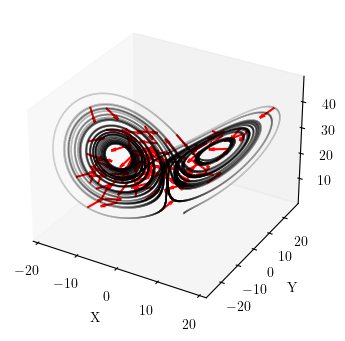

In [16]:
'''u, v, w = np.diff(xn), np.diff(yn), np.diff(zn)

n = 500
x_quiver = xn[:-1:n]
y_quiver = yn[:-1:n]
z_quiver = zn[:-1:n]
u_quiver = u[::n]
v_quiver = v[::n]
w_quiver = w[::n]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xn, yn, zn, c='k', s=0.005, alpha=0.6)
ax.quiver(x_quiver, y_quiver, z_quiver, u_quiver, v_quiver, w_quiver, length=5, normalize=True, color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.grid(False)

plt.show()'''

In [17]:
'''data1 = sol.y
data2 = sol_perm
data3 = stochastic.T'''

In [18]:
#X = np.array(([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]))

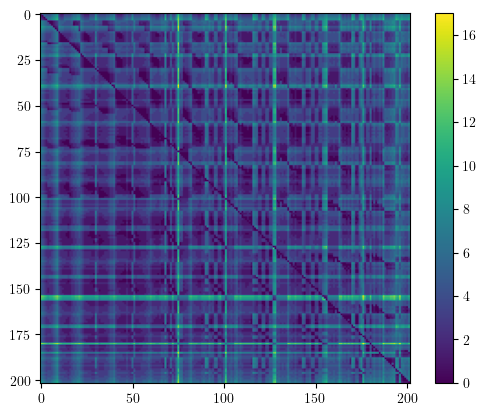

In [19]:
#D1 = data2distancematrix(data1, X)

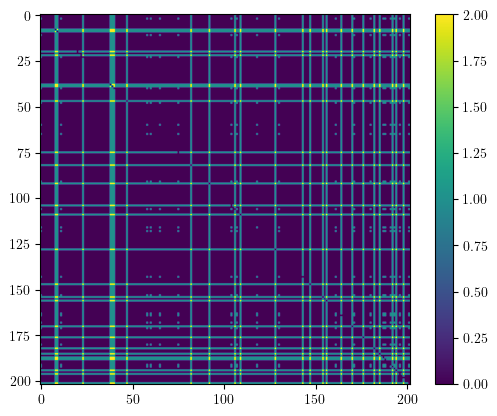

In [20]:
#D2 = data2distancematrix(data2, X)

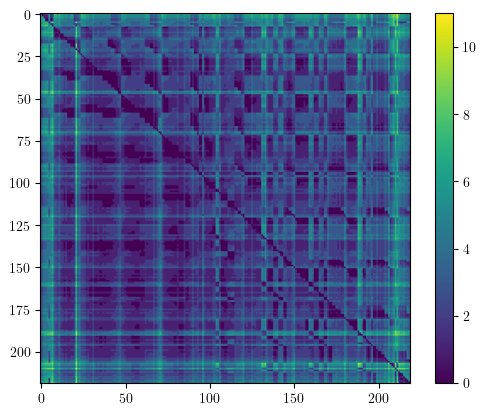

In [21]:
#D3 = data2distancematrix(data3, X)

In [22]:
#flagser1 = flagser_persistence.fit_transform(D1)

In [23]:
#flagser2 = flagser_persistence.fit_transform(D2)

In [24]:
#flagser3 = flagser_persistence.fit_transform(D3)

In [25]:
'''plot = flagser_persistence.plot(flagser1)
plot.update_layout(
    # title=rf"$h_{{1}} = {h:.2f}$",
    font_size=35,
    title_x=0.5,
    font_color="black",
    font_family='Times New Roman',
    legend_bordercolor='#000000',
    legend_borderwidth=1,
    #xaxis=dict(showticklabels=False),
    #yaxis=dict(showticklabels=False)
    # legend=dict(title_font_family="Times New Roman", font=dict(size=35))
)
plot.update_traces(
    marker=dict(size=12)
    # name = r'$H_{0}$'
)
# plot.write_image(f"Flag1_Persistence.png")
plot.show()'''


In [26]:
'''plot = flagser_persistence.plot(flagser2)
plot.update_layout(
    # title=rf"$h_{{1}} = {h:.2f}$",
    font_size=35,
    title_x=0.5,
    font_color="black",
    font_family='Times New Roman',
    legend_bordercolor='#000000',
    legend_borderwidth=1,
    #xaxis=dict(showticklabels=False),
    #yaxis=dict(showticklabels=False)
    # legend=dict(title_font_family="Times New Roman", font=dict(size=35))
)
plot.update_traces(
    marker=dict(size=12)
    # name = r'$H_{0}$'
)
# plot.write_image(f"Flag2_Persistence.png")
plot.show()'''


In [27]:
'''plot = flagser_persistence.plot(flagser3)
plot.update_layout(
    # title=rf"$h_{{1}} = {h:.2f}$",
    font_size=35,
    title_x=0.5,
    font_color="black",
    font_family='Times New Roman',
    legend_bordercolor='#000000',
    legend_borderwidth=1,
    #xaxis=dict(showticklabels=False),
    #yaxis=dict(showticklabels=False)
    # legend=dict(title_font_family="Times New Roman", font=dict(size=35))
)
plot.update_traces(
    marker=dict(size=12)
    # name = r'$H_{0}$'
)
# plot.write_image(f"Flag3_Persistence.png")
plot.show()'''


In [28]:
def plot_barcodes(persistences, spacing=0.01):

    persistences = persistences.reshape(-1, 3)

    # Extract unique homology classes
    homology_classes = np.unique(persistences[:, 2])
    num_classes = len(homology_classes)
    
    fig, ax = plt.subplots(num_classes, 1, figsize=(8, 4 * num_classes), sharex=True)
    
    if num_classes == 1:
        ax = [ax]
    
    for i, h_class in enumerate(homology_classes):
        class_intervals = persistences[persistences[:, 2] == h_class][:, :2]
        # ax[i].set_title(fr"Barcode for $H_{int(h_class)}$")
        for j, (birth, death) in enumerate(class_intervals):
            y = j * spacing  # Add spacing between the bars
            ax[i].plot([birth, death], [y, y])
            # ax[i].scatter([birth, death], [y, y], c='b', s=10)
        ax[i].set_xlabel("Filtration value")
        ax[i].set_ylabel(rf"$Dim_{int(h_class)}$")
        ax[i].set_ylim(-spacing, len(class_intervals) * spacing)  # Set the y-limit to fit all bars
        ax[i].set_yticks([])

    plt.tight_layout()
    plt.show()

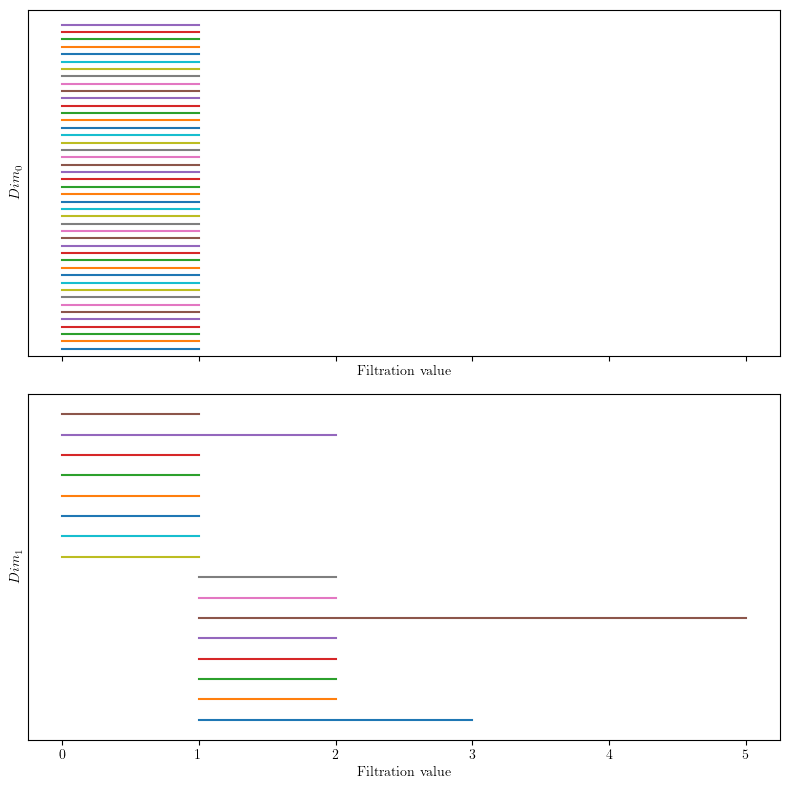

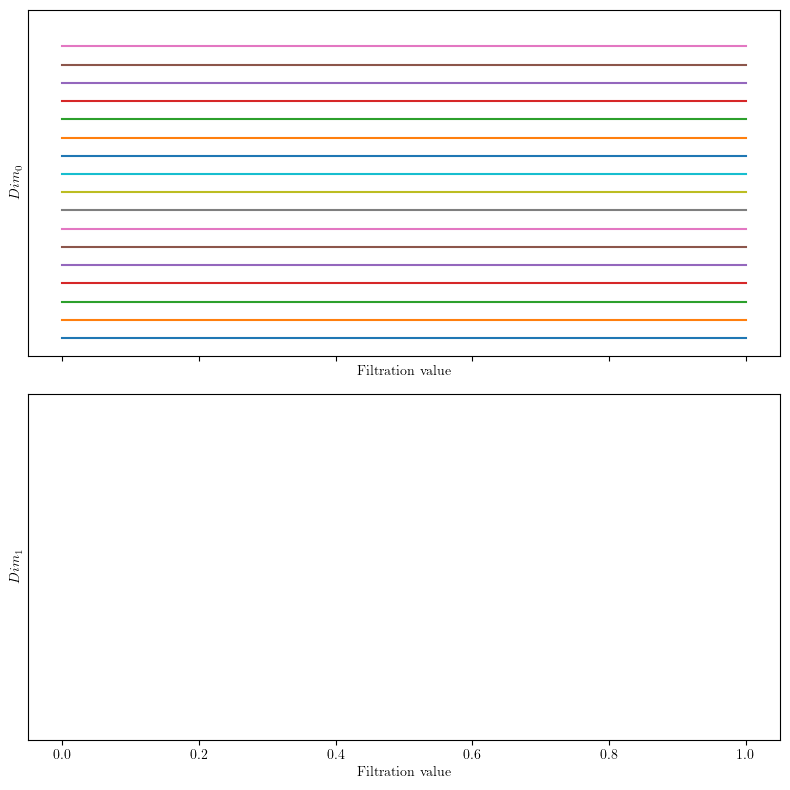

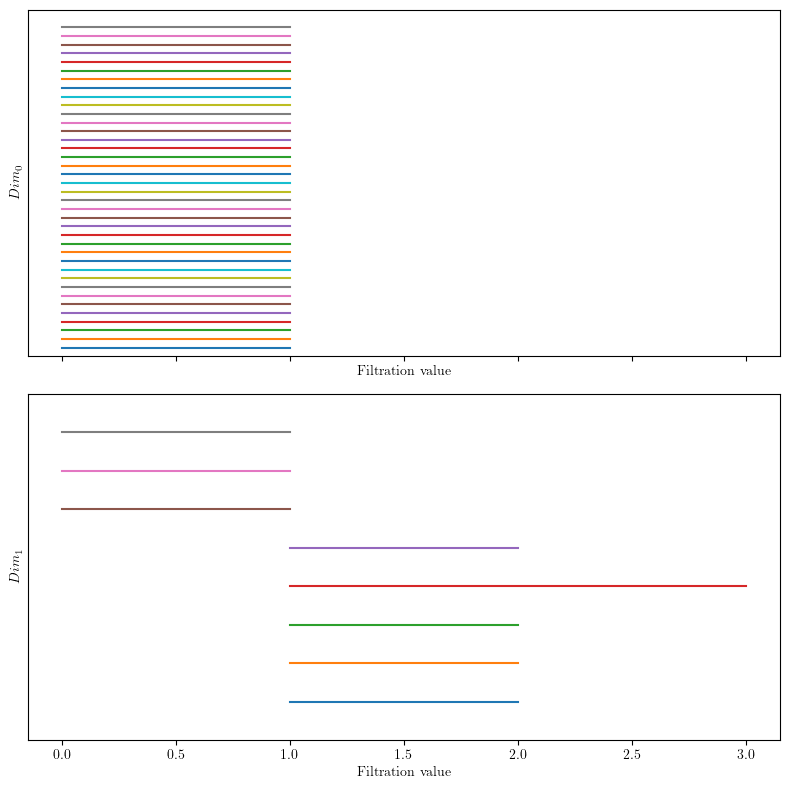

In [29]:
'''plot_barcodes(flagser1)
plot_barcodes(flagser2)
plot_barcodes(flagser3)'''

# Running rips on lorenz

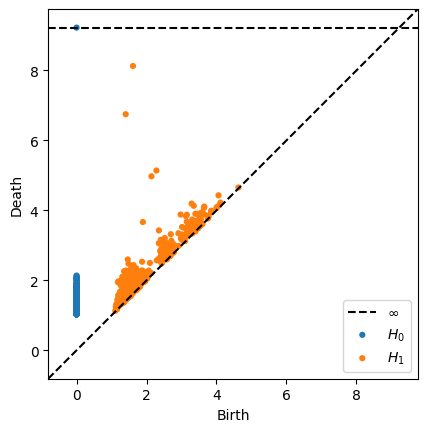

In [161]:
'''from ripser import ripser
from persim import plot_diagrams

dgms = ripser(sol.y.T, n_perm=1000)['dgms']
# dgms = ripser(sol_perm.T, n_perm=1000)['dgms']
plot_diagrams(dgms, show = True)'''

In [162]:
def plot_barcodes(diagrams, spacing=0.1):
    fig, ax = plt.subplots(len(diagrams), 1, figsize=(8, 4), sharex=True)
    
    if len(diagrams) == 1:
        ax = [ax]
    
    for i, dgms in enumerate(diagrams):
        # ax[i].set_title(fr"Barcode for $H_{i}$")
        for j, (birth, death) in enumerate(dgms):
            y = j * spacing  # Add spacing between the bars
            # ax[i].plot([birth, death], [y, y], c='k')
            ax[i].plot([birth, death], [y, y])
            # ax[i].scatter([birth, death], [y, y], c='b', s=10)
        ax[i].set_xlabel("Filtration value")
        ax[i].set_ylabel(rf"$Dim_{int(i)}$")
        ax[i].set_ylim(-spacing, len(dgms) * spacing)  # Set the y-limit to fit all bars

    plt.tight_layout()
    plt.show()

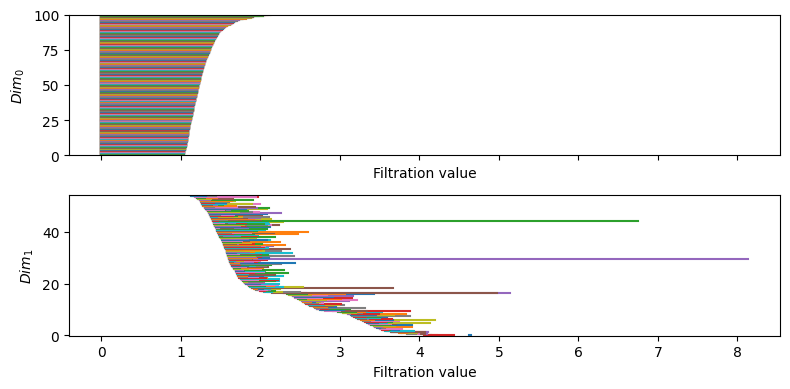

In [163]:
#plot_barcodes(dgms)